In [2]:
import time
import warnings
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import pandas as pd
import polars as pl
pl.enable_string_cache(True)

warnings.filterwarnings('ignore')

from feature_engine.encoding import OrdinalEncoder
from feature_engine.creation import CyclicalFeatures
# from feature_engine.selection import DropFeatures
# from feature_engine.creation import MathFeatures

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

seed=42

    Unfortunately, using the whole dataset for training results in running out of memory too early. 

    Hence, for every district, those GEOHASHs with top 20 mean traffic density will be chosen. This way, we get data points from all districts in Istanbul and most importantly, reduce the amount of data to train.

    As seen from the image below, those GEOHASH represented in red are chosen and the ones in yellow are filtered out.

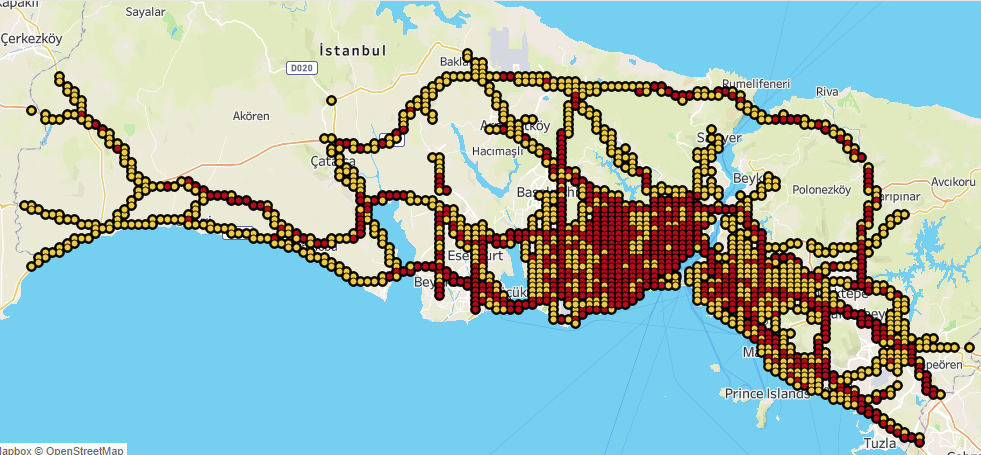

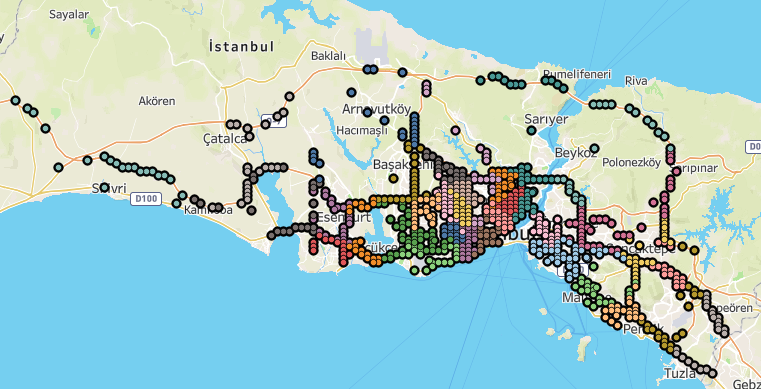

In [3]:
top_TD_GH_by_district = np.array(
    pl.scan_parquet("datasets/19_model/train.zstd")
    .groupby(['DISTRICT', 'GEOHASH'])
    .agg(pl.col(['NUMBER_OF_VEHICLES']).mean())
    .sort(['DISTRICT', 'NUMBER_OF_VEHICLES'], descending=True)
    .with_columns(pl.col('NUMBER_OF_VEHICLES').rank('dense', descending=True).over('DISTRICT').alias('TD_row'))
    .filter(pl.col('TD_row').le(20))
    .select('GEOHASH')
    .collect(streaming=True)\
        ['GEOHASH']
    .to_list()
    # .to_pandas()
    # .to_excel("datasets/18_Viz/top_10_td_gh_district.xlsx", index=False)
)

len(top_TD_GH_by_district)

720

In [ ]:
# Train set
X_train = (
    pl.read_parquet("datasets/19_model/train.zstd")
    .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
    .drop('NUMBER_OF_VEHICLES')
    .to_pandas()
    .set_index('DATE_TIME')
)

y_train = (
    pl.read_parquet("datasets/19_model/train.zstd")
    .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
    .select(['DATE_TIME', 'NUMBER_OF_VEHICLES'])
    .to_pandas()
    .set_index('DATE_TIME')
)

# Validation set
X_valid = (
    pl.read_parquet("datasets/19_model/valid.zstd")
    .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
    .drop('NUMBER_OF_VEHICLES')
    .to_pandas()
    .set_index('DATE_TIME')
)

y_valid = (
    pl.read_parquet("datasets/19_model/valid.zstd")
    .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
    .select(['DATE_TIME', 'NUMBER_OF_VEHICLES'])
    .to_pandas()
    .set_index('DATE_TIME')
)

X_train.head()

In [ ]:
y_train.head()

In [ ]:
X_train.info()

In [ ]:
X_train.isnull().sum()

In [ ]:
# Unique GEOHASH count
total_gh = len(X_train['GEOHASH'].unique())
total_gh

In [ ]:
cat_cols = [col for col in X_train.columns if X_train[col].dtype=='category']
time_cols = ['DAY', 'MONTH', 'HOUR', 'DAYOFWEEK'] #excluding year

print('String columns:', cat_cols)
print('Time columns:', time_cols)

# Encode categorical columns with numbers.
ord_encoder=OrdinalEncoder(encoding_method='arbitrary', variables=cat_cols)

# Convert time features such as day, month, hour and day of week to cyclical features to maintain cyclicity.
cf_encoder = CyclicalFeatures(variables=time_cols, drop_original=True)


#Creating encoder pipeline
encoders = make_pipeline(
    (ord_encoder), #Ordinal Encoder
    (cf_encoder), #Cyclical Feature
)

In [ ]:
# XGBoost
xgb=XGBRegressor(
    n_estimators=100,
    max_depth=6,
    eta=0.1,
    gamma=2,
    n_jobs=-1, 
    random_state=seed,
    eval_metric="rmse"
)

#Putting whole pipeline together
pipeline = make_pipeline(
    (encoders), #Encoders
    (xgb) #XGBoost
)

print("Pipeline Created!")

#### Visualizing how Cross Validation will be carried out

In [ ]:
# choosing only a sample of dataset
sample = (
    pd.concat([X_train, y_train], axis=1)
    .query("GEOHASH in ('sxk90n', 'sxk3pn')")
)

N=2
H=24

#Visualizing how the cross validation will be done
n_split = 10

max_train_size=None
test_size=None

# max_train_size=N*H*800
# test_size=N*H*90

sample_tss = TimeSeriesSplit(
    n_splits=n_split, 
    max_train_size=max_train_size, 
    test_size=test_size, 
    gap=N*H*7
)

fig, axs = plt.subplots(n_split, 1, figsize=(10, n_split), sharex=True, tight_layout=True)

fold = 0
for train_idx, val_idx in sample_tss.split(sample):
    train_cv = sample.iloc[train_idx]
    test_cv = sample.iloc[val_idx]
    
    train_cv.plot(y='NUMBER_OF_VEHICLES', ax=axs[fold], label='Training Set',
                  title=f'Data Train/Test Split Fold {fold + 1}', legend=False)
    
    test_cv.plot(y='NUMBER_OF_VEHICLES', ax=axs[fold], label='Test Set', legend=False)
    
    axs[fold].axvline(test_cv.index.min(), color='black', ls='--')
    
    fold += 1

axs.flatten()[0].legend(ncol=2, loc='upper right', );

#### Cross Validation

In [ ]:
def plot_cv_results(pipeline):
    
    feat_scores=pipeline.steps[-1][-1].feature_importances_
    feat_names=pipeline.steps[-1][-1].feature_names_in_

    #Creating a dataframe for feature importance
    feat_imp_df = (
        pd.DataFrame({'features' : feat_names,'importance' : np.abs(np.round(feat_scores, 3))})
        .set_index('features').sort_values('importance')
    )
    
    #Print Features with Low Importance
    print("Features with Low Importance:")
    print(np.sort(feat_imp_df.query("importance<=0.001").index))
    
    #Plot
    ax = feat_imp_df.plot(kind='barh', edgecolor='k', figsize=(3, 20))
    ax.bar_label(ax.containers[0], fontsize=13, padding=3);
    ax.legend().remove()
    ax.set_title("Feature Importance")
    
    plt.show();

In [ ]:
def cv_and_validate(cv, pipeline, X_train, y_train, X_valid, y_valid):

    rmse_values = []

    count = 1
    # Loop through the folds
    print("Cross Validating.....")
    print()
    
    # start timer
    loop_time = time.time()

    for train_index, test_index in cv.split(X_train, y_train):

        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # Fit the model on the train data
        pipeline.fit(X_train_cv, y_train_cv)

        # Predict on the test data
        y_pred = np.round(pipeline.predict(X_test_cv))

        # Calculate the mean squared error
        rmse = mean_squared_error(y_test_cv, y_pred, squared=False)

        print(f"cv #{count}: RMSE = {rmse:.3f} | Time taken: {(time.time() - loop_time)/60:.2f} min")

        rmse_values.append(rmse)
        count += 1
        loop_time = time.time()
        
    # Print the average MSE over all folds
    print()
    print(f"Average Train RMSE: {np.mean(rmse_values):.3f} ± {np.std(rmse_values):.2f}")


    #Predicting on Validation set
    predictions = pipeline.predict(X_valid)
    test_rmse = mean_squared_error(y_valid, predictions, squared=False)

    print(f"Test RMSE Score: {test_rmse:.3f}")
    print()

    # Plot Feature importance
    plot_cv_results(pipeline=pipeline)

    return predictions

In [ ]:
%%time

N=total_gh
H=24
n_split=10

max_train_size=None
test_size=None

tss = TimeSeriesSplit(
    n_splits=n_split, 
    max_train_size=max_train_size, 
    test_size=test_size, 
    gap=N*H*7
)

predicted_td = cv_and_validate(cv=tss, 
                               pipeline=pipeline,  
                               X_train=X_train,
                               y_train=y_train,
                               X_valid=X_valid,
                               y_valid=y_valid)